# ⭐Imports


In [1]:
from processing_functions import *
%matplotlib inline

TensorFlow Version:  2.1.0


---

# ⭐ Building Classifier

## 🔵 Step 1: Preprocess Data (Create Dataset)

1. Preprocess Signal & Background Data
2. Concatenate & Shuffle signal/background data
3. Convert to tf.data.Dataset object



In [2]:
# Load Previously saved data
# MAIN
data_s = np.array(pd.read_csv('data_s_csv').iloc[:, 1:])
data_b = np.array(pd.read_csv('data_b_csv').iloc[:, 1:])

# # LOG
# data_s = np.array(pd.read_csv('data_s_log_csv').iloc[:, 1:])
# data_b = np.array(pd.read_csv('data_b__log_csv').iloc[:, 1:])

# # NORMAL
# data_s = np.array(pd.read_csv('data_s_normal_csv').iloc[:, 1:])
# data_b = np.array(pd.read_csv('data_b_normal_csv').iloc[:, 1:])

# # Import, Preprocess, Create Dataset
# start = time.time()
# data_s = create_dataset_CNN('dataset_signal.dat')
# data_b = create_dataset_CNN('dataset_background.dat')
# end = time.time()
# print('Time taken: {:.2f} mins'.format((end-start)/60))

# # Save Datasets
# pd.DataFrame(data_s).to_csv('data_s_norm_csv')
# pd.DataFrame(data_b).to_csv('data_b_norm_csv')

In [3]:
# Create s&b labels
slabels = np.ones(data_s.shape[0]//40)
blabels = np.zeros(data_b.shape[0]//40)

# Concatenate examples and labels
data = np.concatenate((data_s, data_b), axis=0)
labels = np.concatenate((slabels, blabels), axis=0)

# Define useful quantities
num_of_examples = data.shape[0] // 40     # divide by 40 because 1st dim is 40 * num_of_examples
num_of_labels = labels.shape[0]
print('Total Events:', num_of_examples)
print('Total Labels:', num_of_labels)

# Reshape examples (for CNN)
examples = data.reshape(num_of_examples, 40, 40, 1)
print('Shape: ', examples.shape)

Total Events: 29449
Total Labels: 29449
Shape:  (29449, 40, 40, 1)


### 🔴 Train-Val-Test Split

In [4]:
from sklearn.model_selection import train_test_split

train_examples, test_examples, train_labels, test_labels = train_test_split(examples, labels, test_size=0.15, random_state=42)
train_examples, val_examples, train_labels, val_labels = train_test_split(train_examples, train_labels, test_size=0.18, random_state=42)

print('Train: ', train_examples.shape, train_labels.shape)
print('Val: ', val_examples.shape, val_labels.shape)
print('Test: ', test_examples.shape, test_labels.shape)

Train:  (20525, 40, 40, 1) (20525,)
Val:  (4506, 40, 40, 1) (4506,)
Test:  (4418, 40, 40, 1) (4418,)


### 🔴 Convert to tf.data.Dataset

In [5]:
train_data = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
val_data = tf.data.Dataset.from_tensor_slices((val_examples, val_labels))
test_data = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))

print(train_data)
print(val_data)
print(test_data)

<TensorSliceDataset shapes: ((40, 40, 1), ()), types: (tf.float64, tf.float64)>
<TensorSliceDataset shapes: ((40, 40, 1), ()), types: (tf.float64, tf.float64)>
<TensorSliceDataset shapes: ((40, 40, 1), ()), types: (tf.float64, tf.float64)>


## 🔵 Step 2: Create Batches

Baatches: number of events with which you update trained parameters once

- `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

- `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Theory guide: https://www.tensorflow.org/guide/data_performance#prefetching

In [6]:
batch_size = 64

def normalise(image, label):
    image = tf.cast(image, tf.int64)                 # Set dtype to int64
    label = tf.cast(label, tf.int64)
    #image /= np.amax(image.numpy())                    # Normalise Image
    #image = tf.image.resize(image, (pixels, pixels, 1))   # Resize image to 40x40
    return image, label



train_batches = train_data.cache().shuffle(num_of_examples).map(normalise).batch(batch_size, drop_remainder=True).prefetch(1)

val_batches = val_data.cache().shuffle(num_of_examples).map(normalise).batch(batch_size, drop_remainder=True).prefetch(1)  # or prefetch(buffer_size=tf.data.experimental.AUTOTUNE) 

test_batches = test_data.cache().shuffle(num_of_examples).map(normalise).batch(batch_size, drop_remainder=True).prefetch(1)

In [7]:
num_of_batches_train = len(train_labels) // batch_size
num_of_batches_val = len(val_labels) // batch_size
num_of_batches_test = len(test_labels) // batch_size

print(train_batches)
print('\ntrain, val, test: ', num_of_batches_train, num_of_batches_val, num_of_batches_test)

<PrefetchDataset shapes: ((64, 40, 40, 1), (64,)), types: (tf.int64, tf.int64)>

train, val, test:  320 70 69


### 🔴 Visualise Data  
(TRY REMOVING NORMALISATION FROM PREPROCESSING (create_dataset), THEN DISPLAY IMAGE, THEN WHEN CREATING BATCHES USE .MAP(NORMALISE) TO NORMALISE IMAGES)

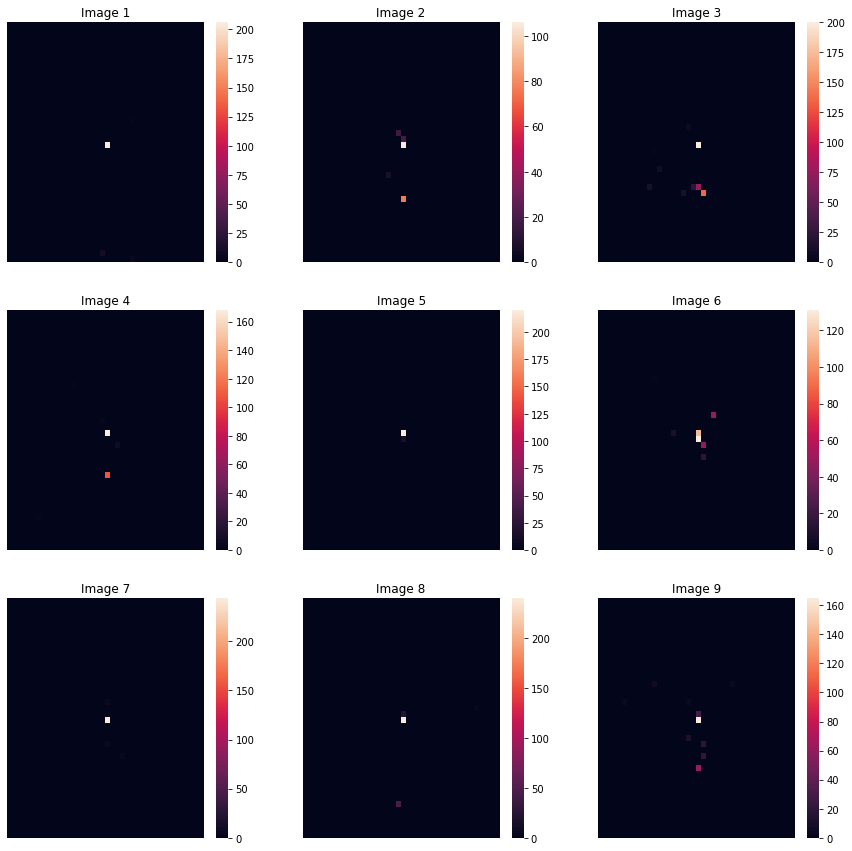

In [8]:
plt.figure(figsize=(15,15))

for images, labels in train_batches.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        sns.heatmap(images[i].numpy().reshape(40, 40))
        #plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Image {}'.format(i+1))
        plt.axis("off")

## 🔵 Step 3: Build the Model

### 🔴 Learning Curve
Determine whether a larger dataset could improve performance

In [9]:
# input_shape=(40, 40, 1)
# kernel_size = 2
# padding='valid'
# activation = 'tanh'

# prop = [0.1, 0.2, 0.4, 0.6, 0.8, 1]
# loss_list = []
# accuracy_list = []

# for i in prop:
#     model = tf.keras.Sequential([
#                   tf.keras.Input(shape=input_shape),
#                   tf.keras.layers.Conv2D(16, kernel_size=kernel_size, padding=padding, activation=activation),
#                   tf.keras.layers.MaxPooling2D(),
#                   tf.keras.layers.Conv2D(32, kernel_size=kernel_size, padding=padding, activation=activation),
#                   tf.keras.layers.MaxPooling2D(),
#                   tf.keras.layers.Conv2D(64, kernel_size=kernel_size, padding=padding, activation=activation),
#                   tf.keras.layers.MaxPooling2D(),
#                   tf.keras.layers.Flatten(),
#                   tf.keras.layers.Dense(128, activation=activation),
#                   tf.keras.layers.Dense(2, activation = 'softmax')
#         ])


#     # Compile Model
#     model.compile(optimizer='adam',
#                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                   metrics=['accuracy'])


#     print('\n\n', i, '\n')

#     # Fit model to training data
#     EPOCHS = 4

#     history = model.fit(train_batches.take(int(i*num_of_batches_train)), 
#               epochs=EPOCHS,
#               validation_data=val_batches.take(int(i*num_of_batches_val)), 
#               verbose=0
#               )
    
#     loss, accuracy = model.evaluate(test_batches, verbose=0)
#     loss_list.append(loss)
#     accuracy_list.append(accuracy)
    
#     loss, accuracy = model.evaluate(test_batches, verbose=0)
#     print('Accuracy on the Test Set: {:.1%}'.format(accuracy))

In [10]:
# plt.plot(np.array(prop)*100, accuracy_list, linestyle='--', marker='o')
# plt.xlabel('% of Dataset Used')
# plt.ylabel('Accuracy')
# plt.title('Learning Curve')
# plt.show()

### 🔴 Compile the Model
- **Optimizer** -- Determines how the model is updated based on the data it sees and its loss function
- **Loss Function** -- Measures how accurate the model is during training
- **Metrics** -- Monitors the training and testing steps. 

### 🔴 Fit the Model

**Early Stopping**: <br /> 
Stop training when there is no improvement in the validation loss for 5 consecutive epochs or when metric gain is less than 0.001

**Save Best**: <br />
Saves the best model

## Notes
#### Activation Function (non normalised)
- **Relu**: sometimes results in all predictions being 0 
- **tanh**: solves this issue; accuracy (n = 1): 73
- **softsign**: solves and performs similarly to tanh
- **elu**: solves and performs slightly better than tanh

#### Activation Function (log)
- **softsign**: only softsign works. accuracy: 67

#### Activation Function (normal)
- Nothing has worked

### Other hyperparameters
- kernel_size = 2, 3, 5, 7 perform best (very similarly to one another)
- padding = 'valid', 'same' result in very similar performance
- filters: tried small (8 in all) to large (256 in all) and they perform similarly to one another. 

In [11]:
# input_shape=(40, 40, 1)
# kernel_size = 2
# padding='valid'
# activation = 'tanh'

# activations = ['elu', 'exponential', 'hard_sigmoid', 'linear', 'relu', 'selu', 'sigmoid', 'softmax', 'softplus', 'softsign', 'tanh']
# kernels = [1, 3, 5, 7, 9, 11]
# paddings = ['valid', 'same']
# filters = [8, 16, 64, 256, 512]

# for activation in activations:

#     model = tf.keras.Sequential([
#               tf.keras.Input(shape=input_shape),
#               tf.keras.layers.Conv2D(16, kernel_size=kernel_size, padding=padding, activation=activation),
#               tf.keras.layers.Dropout(0.2),
#               tf.keras.layers.MaxPooling2D(),
#               tf.keras.layers.Conv2D(32, kernel_size=kernel_size, padding=padding, activation=activation),
#               tf.keras.layers.Dropout(0.2),
#               tf.keras.layers.MaxPooling2D(),
#               tf.keras.layers.Conv2D(64, kernel_size=kernel_size, padding=padding, activation=activation),
#               tf.keras.layers.Dropout(0.2),
#               tf.keras.layers.MaxPooling2D(),
#               tf.keras.layers.Flatten(),
#               tf.keras.layers.Dense(128, activation=activation),
#               tf.keras.layers.Dropout(0.2),
#               tf.keras.layers.Dense(2, activation = 'softmax')
#     ])

#     #model.summary()

#     # Compile Model
#     model.compile(optimizer='adam',
#                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                   metrics=['accuracy'])

    
#     # Callbacks
#     early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta = 0.001)
#     save_best = tf.keras.callbacks.ModelCheckpoint('./model_recent.h5', monitor='loss', save_best_only=True)

#     print('\n\n', activation, '\n')

#     # Fit model to training data
#     EPOCHS = 15

#     history = model.fit(train_batches, 
#               epochs=EPOCHS,
#               callbacks= [early_stopping, save_best],
#               validation_data=val_batches, 
#               verbose=1
#               )
    
#     loss, accuracy = model.evaluate(test_batches, verbose=0)

#     print('\nLoss on the Test Set: {:,.3f}'.format(loss))
#     print('Accuracy on the Test Set: {:.1%}'.format(accuracy))

## 🔵 Step 4: Model-Complexity Graph 
How performance changes with epochs

In [12]:
# training_accuracy = history.history['accuracy']
# validation_accuracy = history.history['val_accuracy']

# training_loss = history.history['loss']
# validation_loss = history.history['val_loss']

# epochs_range=range(len(training_accuracy))

# plt.figure(figsize=(16, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
# plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, training_loss, label='Training Loss')
# plt.plot(epochs_range, validation_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()


## 🔵 Step 5: Evaluate Model on Test Batches

In [13]:
model = tf.keras.models.load_model('model_relu_7570.h5')
model.summary()

loss, accuracy = model.evaluate(test_batches, verbose=0)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.1%}'.format(accuracy))

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 40, 40, 16)        160       
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 20, 20, 32)        4640      
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 1600)            

### 🔴 Make Predictions

In [14]:
# class_names = ['Background', 'Signal']

# for event, label in test_batches.take(1):
#     ps = model.predict(event)
#     images = event.numpy().squeeze()
#     labels = label.numpy()


# plt.figure(figsize=(25,25))

# for n in range(15):
#     plt.subplot(6,5,n+1)
#     sns.heatmap(images[n])
#     #plt.imshow(images[n], cmap = plt.cm.binary)
#     color = 'green' if np.argmax(ps[n]) == labels[n] else 'red'
#     plt.title(class_names[np.argmax(ps[n])], color=color)
#     plt.axis('off')

In [15]:
# for event, label in train_batches.take(1):
#     ps = model.predict(event)
#     first_image = event.numpy().squeeze()[0]
  
  
#     fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
#     #sns.heatmap(first_image)
#     ax1.imshow(first_image)
#     ax1.axis('off')
#     ax2.barh(np.arange(2), ps[0])
#     ax2.set_aspect(0.1)
#     ax2.set_yticks(np.arange(2))
#     ax2.set_yticklabels(np.arange(2))
#     ax2.set_title('Class Probability')
#     ax2.set_xlim(0, 1.1)
#     plt.tight_layout()

## 🔵 Step 6: Build Confusion Matrix (unseen test data)

Guide:
https://kapernikov.com/tutorial-image-classification-with-scikit-learn/

In [19]:
model0 = tf.keras.models.load_model('model_elu_7470.h5')
model1 = tf.keras.models.load_model('model_tanh_7360.h5')
model2 = tf.keras.models.load_model('model_relu_7570.h5')

models = [model0, model1, model2]

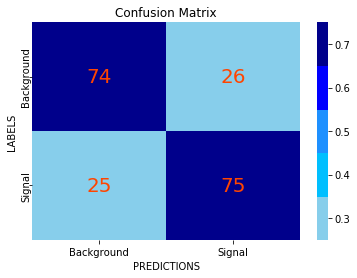

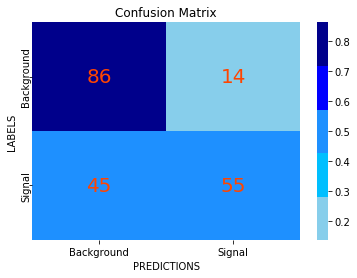

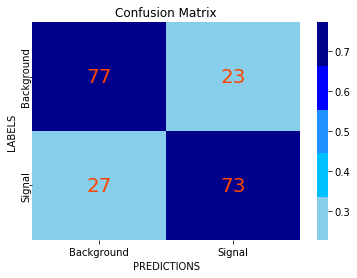

In [20]:
cmx_tf(models, test_batches, num_of_batches_test)

## 🔵 Step 7: ROC Curve

For relu activation function (i.e. model outputs two probabilities per event, [P(background), P(signal)]

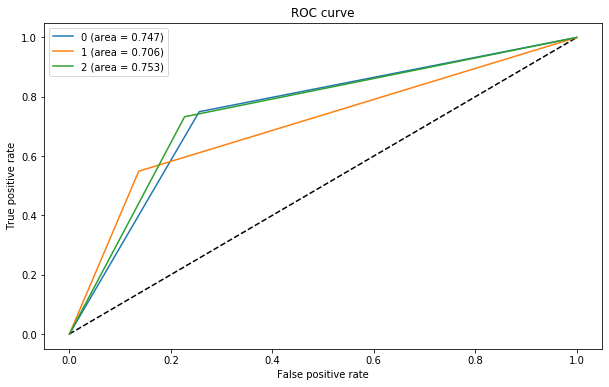

In [21]:
ROC3_tf(model0, model1, model2, test_batches, num_of_batches_test)